# Analyze Watson Assistant Effectiveness

![overall_effectiveness.png](https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/notebook/imgs/effectiveness_overall.png)

### Introduction

As described in <a href="https://github.com/watson-developer-cloud/assistant-improve-recommendations-notebook/raw/master/notebook/IBM%20Watson%20Assistant%20Continuous%20Improvement%20Best%20Practices.pdf" target="_blank" rel="noopener noreferrer">Watson Assistant Continuous Improvement Best Practices</a>, this notebook will help you understand relative performance of each intent and entity, the confusion between your intents, as well as the root cause of utterance issues. This information helps you prioritize your improvement effort. 

The pre-requisite for running this notebook is a collection of annotated utterances. This notebook assumes familiarity with Watson Assistant and concepts such as workspaces, intents and training examples. 

### Programming language and environment

Some familiarity with Python is recommended. This notebook runs on Python 3.5+ environment.
***

## Table of contents
1. [Configuration and setup](#setup)<br>
    1.1 [Apply global CSS styles](#setup1)<br>
    1.2 [Install required Python libraries](#setup2)<br>
    1.3 [Import functions used in the notebook](#setup3)<br>
    1.4 [Specify annotation file](#setup4)<br>
2. [Load and format data](#load)<br>
3. [Generate summary metrics](#summ_metrics)<br>
    3.1 [Generate confusion matrix](#summ_metrics1)<br>
    3.2 [Calculate True Positive (TP), False Positive (FP), False Negative (FN), and True Negative (TN)](#summ_metrics2)<br>
    3.3 [Calculate the total number of utterances, as well as the numbers of correct and wrong utterances](#summ_metrics3)<br>
    3.4 [Calculate average helpfulness and its variance over different intents](#summ_metrics4)<br>
    3.5 [Calculate average precision and variance](#summ_metrics5)<br>
    3.6 [Display the summarized results](#summ_metrics6)<br>
    3.7 [Summarize the root cause](#summ_metrics7)<br>
4. [Perform intent analysis](#intent_analysis)<br>
    4.1 [Determine worst overall performing intents](#intent_analysis1)<br>
    4.2 [Determine the worst precision intents](#intent_analysis2)<br>
    4.3 [Determine the worst recall intents](#intent_analysis3)<br>
    4.4 [Determine confused intent pairs](#intent_analysis4)<br>
5. [Perform entity analysis](#entity_analysis)<br>
6. [Perform dialog analysis](#dialog_analysis)<br>
7. [Summary and recommendation](#summary)<br>

## <a id="setup"></a> 1. Configuration and setup

In this section, we import required libraries and functions and add data access credentials.

### <a id="setup1"></a> 1.1 Import and apply global CSS styles

In [1]:
from IPython.display import display, HTML
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/css/custom.css
HTML(open('custom.css', 'r').read())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   348  100   348    0     0    348      0  0:00:01 --:--:--  0:00:01  1017


### <a id="setup2"></a> 1.2 Install required Python libraries

In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import OrderedDict
from IPython.display import Markdown as md
import re
import ast

### <a id="setup3"></a> 1.3 Import functions used in the notebook

In [3]:
# Import function module files
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/python/cos_op.py
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/python/visualize_func.py
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/python/computation_func.py

# Import functions from cos_functions module
from cos_op import generate_link
from computation_func import round_decimal
from visualize_func import table_styles
from visualize_func import make_bar
from cos_op import generate_excel_effectiveness

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7170  100  7170    0     0   7170      0  0:00:01 --:--:--  0:00:01 22406
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10166  100 10166    0     0  10166      0  0:00:01 --:--:--  0:00:01 28717
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14524  100 14524    0     0  14524      0  0:00:01 --:--:--  0:00:01 41261


### <a id="setup4"></a> 1.4 Specify annotation file

In order to run the effectiveness analysis, you will need to specify the path of your annotated file.

In [4]:
# The following code is for using demo annotation data
import requests
print('Loading workspace data from Watson developer cloud GitHub repo ... ', end='')
workspace_data = requests.get("https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/notebook/data/annotation.xlsx").content
with open('annotation.xlsx', 'wb') as out:
    out.write(workspace_data)
print('completed!')

annotation_file = 'annotation.xlsx'

Loading workspace data from Watson developer cloud GitHub repo ... completed!


## <a id="load"></a> 2. Load and format data 
Here, we load the annotated problematic logs for analysis. Remember add your sheet name into `sheet_name=''`.

In [5]:
column_list = [
    'log_id',
    'conversation_id',
    'timestamp',
    'customer_id',
    'utterance_text',
    'response_text',
    'top_intent',
    'top_confidence',
    'intent_2',
    'intent_2_confidence',
    'confidence_gap',
    'intent_3',
    'intent_3_confidence',
    'entities',
    'is_escalated',
    'is_convered',
    'not_convered_cause',
    'dialog_flow',
    'dialog_stack',
    'dialog_request_counter',
    'dialog_turn_counter',
    'correctness',
    'helpfulness',
    'root_cause',
    'correct_intent',
    'new_intent',
    'add_train',
    'missed_entity',
    'new_entity',
    'new_entity_value',
    'new_dialog_logic',
    'wrong_dialog_node',
    'no_dialog_node_triggered'
]

annotated_data = pd.read_excel(annotation_file, sheet_name='data', names=column_list)

## 3. Generate summary metrics<a id="summ_metrics"></a>

Here, we generate the confusion matrix, calculate TP, FP, FN and TN, the total number of utterances, average helpfulness, precision and variance, summarize the possible root causes and display the results.

### <a id="summ_metrics1"></a> 3.1 Generate confusion matrix

A confusion matrix is a table that is often used to describe the performance of a classification model.

In [6]:
# Get intent list
annotated_data['top_intent'] = annotated_data['top_intent'].replace(r'^\s+$', np.nan, regex=True)
annotated_data['correct_intent'] = annotated_data['correct_intent'].replace(r'^\s+$', np.nan, regex=True)
intents = pd.unique(annotated_data[['top_intent', 'correct_intent']].values.ravel())
# Remove NaN
intents=sorted(intents[~pd.isnull(intents)])

# add a ground truth column
annotated_data['ground_truth'] = annotated_data['correct_intent'].fillna(annotated_data['top_intent'])

# calculate number of count per intent based on top intent
num_total_per_intent = pd.DataFrame(annotated_data.groupby('top_intent').size(), intents).fillna(0)

# calculate number of count per intent based on ground truth
num_total_per_intent_gt = pd.DataFrame(annotated_data.groupby('ground_truth').size(), intents).fillna(0)

# Generate confusion matrix
confusion_matrix = confusion_matrix(annotated_data['ground_truth'], annotated_data['top_intent'], labels=intents)

<a id="summ_metrics2"></a>
### 3.2 Calculate True Positive (TP), False Positive (FP), False Negative (FN), and True Negative (TN)
- __True Positives__ of an intent describe cases where the intent classifier correctly classifies utterances as this intent.
- __False Positives__ of an intent describe cases where the intent classifier incorrectly classifies utterances as this intent.
- __False Negatives__ of an intent describe cases where the intent classifier fails to identify utterances as this intent.
- __True Negatives__ of an intent describe cases where the intent classifier correctly identifies that utterances don't belong to this intent.

In [7]:
# Calculate True Positive (TP)
TP = np.diag(confusion_matrix)

# Calculate False Positive (FP)
FP = np.sum(confusion_matrix, axis=0) - TP

# Calculate False Negative (FN)
FN = np.sum(confusion_matrix, axis=1) - TP

# Calculate True Negative (TN)
TN = []
for i in range(len(intents)):
    row_del = np.delete(confusion_matrix, i, 0)
    col_del = np.delete(row_del, i, 1) 
    TN.append(sum(sum(col_del)))

<a id="summ_metrics3"></a>
### 3.3 Calculate the total number of utterances, as well as the numbers of correct and wrong utterances

In [8]:
# Get total number of utterances
total_num = np.sum(TP+FP)

# Get total number of correctly classified utterances
total_correct = np.sum(TP)

# Get total number of incorrectly classified utterances
total_wrong = np.sum(FP)

<a id="summ_metrics4"></a>
### 3.4 Calculate average helpfulness and its variance over different intents
Helpfulness is a metric that identifies responses that may be considered technically correct, but the wording of the response is not satisfying to the user. It could be too long, too general, or just worded awkwardly, thus resulting in an overall ineffective response. <br>
**Note:** The exact definition of helpfulness is subjective and can be defined based on your business goals.  

In [9]:
# Get number of utterances that labeled as helpful per class
num_helpfulness_per_intent = annotated_data.loc[annotated_data['helpfulness']== 'Y'].groupby('ground_truth').size()
num_unhelpfulness_per_intent = annotated_data.loc[annotated_data['helpfulness']== 'N'].groupby('ground_truth').size()

# Get number of utterances per class
num_total_per_intent_helpfulness = num_helpfulness_per_intent.add(num_unhelpfulness_per_intent, fill_value=0)

# Get total number of utterances that labeled as helpful
num_helpfulness = sum(num_helpfulness_per_intent)
num_unhelpfulness = sum(num_unhelpfulness_per_intent)

# Calculate averaged helpfulness
avg_help = np.average(num_helpfulness_per_intent.divide(num_total_per_intent_helpfulness, fill_value=0))

# Calculate helpfulness variance
var_help = np.var(num_helpfulness_per_intent.divide(num_total_per_intent_helpfulness, fill_value=0))

# Calculate helpful utterance percentage per intents
percentage_helpful_intent = num_helpfulness_per_intent.divide(num_total_per_intent_helpfulness, fill_value=0)

# Collect invalid intent for helpfulness metric
invalid_intent_helpfulness = list(set(intents) - set(num_total_per_intent_helpfulness.index.tolist()))

<a id="summ_metrics5"></a>
### 3.5 Calculate average precision and variance
Precision is a metric measuring the performance of intent classifier.

In [10]:
# Calculate precision by intents
TP_FP = TP+FP
precision_list = pd.DataFrame({'True Positives': TP, 'True&False Positive': TP_FP, 'Intents': intents})

# Remove invalid intent
invalid_intent_precision = precision_list[precision_list['True&False Positive']==0]['Intents']
precision_list = precision_list[precision_list['True&False Positive']>0]

# Calculate precision per intent
precision_list['Precision'] = precision_list['True Positives'] / precision_list['True&False Positive'] 

# Calculate averaged precision
avg_prec = np.average(precision_list['Precision'])

# Calculate precision variance
var_prec = np.var(precision_list['Precision'])

<a id="summ_metrics6"></a>
### 3.6 Display the summarized results
Here, we take a look at the summarized results - in text and bar chart form.
#### 3.6.1 Print performance summary

In [11]:
# print Performance Summary
print('===== Performance Summary =====\n')

print('Number of intents: {}'.format(len(intents)))
print('Number of Utterances: {}'.format(total_num))

print('\n\tTop 5 intents based on count of top detected intent:\n')    
for intent, value in num_total_per_intent.sort_values(by=0, ascending=False).head(5)[0].iteritems():
    print('\t\t{:<30}\t{}'.format(intent, value))
print('\n\tBottom 5 intents based on count in top detected intent:\n')    
for intent, value in num_total_per_intent.sort_values(by=0, ascending=True).head(5)[0].iteritems():
    print('\t\t{:<30}\t{}'.format(intent, value))
    
print('\n\tTop 5 intents based on count of ground truth intent:\n')    
for intent, value in num_total_per_intent_gt.sort_values(by=0, ascending=False).head(5)[0].iteritems():
    print('\t\t{:<30}\t{}'.format(intent, value))
print('\n\tBottom 5 intents based on count of ground truth intent:\n')    
for intent, value in num_total_per_intent_gt.sort_values(by=0, ascending=True).head(5)[0].iteritems():
    print('\t\t{:<30}\t{}'.format(intent, value))
    
print('\nCorrect Classified Utterances: {}'.format(total_correct))
print('Incorrectly Classified Utterances: {}\n'.format(total_wrong))

print('- Helpfulness\n')
print('\tHelpful Utterances: {}'.format(num_helpfulness))
print('\tUnhelpful Utterances: {}'.format(num_unhelpfulness))
print('\tAverage Helpfulness Percentage: {}'.format(round_decimal(avg_help,3)))
print('\tHelpfulness Variance: {}\n'.format(round_decimal(var_help,3)))
print('\tTop 5 best performed intents:\n')
for intent, value in percentage_helpful_intent.sort_values(ascending=False).head(5).iteritems():
    print('\t\t{:<30}\t{:4.3f}'.format(intent, round_decimal(value,3)))

print('\n\tTop 5 worst performed intents:\n')
for intent, value in percentage_helpful_intent.sort_values(ascending=True).head(5).iteritems():
    print('\t\t{:<30}\t{:4.3f}'.format(intent, round_decimal(value,3)))

print('\n- Precision\n')
print('\tTrue Positive: {}'.format(sum(TP)))
print('\tFalse Positive: {}'.format(sum(FP)))
print('\tFalse Negative: {}'.format(sum(FP)))
print('\tAverage Precision: {}'.format(round_decimal(avg_prec,3)))
print('\tPrecision Variance: {}\n'.format(round_decimal(var_prec,3)))

print('\tTop 5 best performed intents:\n')    
for row in precision_list.sort_values(by=['Precision'], ascending=False).head(5).iterrows():
    print('\t\t{:<30}\t{:4.3f}'.format(row[1]['Intents'], round_decimal(row[1]['Precision'],3)))

print('\n\tTop 5 worst performed intents:\n')
for row in precision_list.sort_values(by=['Precision'], ascending=True).head(5).iterrows():
    print('\t\t{:<30}\t{:4.3f}'.format(row[1]['Intents'], round_decimal(row[1]['Precision'],3)))

if len(invalid_intent_helpfulness) > 0:
    print('\n*Note*: the following intents are ignored when calculating Helpfulness due to missing values\n')
    for intent in invalid_intent_helpfulness:
        print('\t{}'.format(intent))
        
if len(invalid_intent_precision) > 0:
    print('\n*Note*: the following intents are ignored when calculating Precision due to the sum of True and False Positive is zero\n')
    for intent in invalid_intent_precision:
        print('\t{}'.format(intent))

===== Performance Summary =====

Number of intents: 25
Number of Utterances: 2455

	Top 5 intents based on count of top detected intent:

		turn_on                       	755
		locate_amenity                	721
		capabilities                  	205
		turn_off                      	129
		weather                       	112

	Bottom 5 intents based on count in top detected intent:

		selections                    	2
		improving_system              	3
		interface_issues              	4
		navigation                    	4
		system_reliance               	5

	Top 5 intents based on count of ground truth intent:

		capabilities                  	841
		locate_amenity                	670
		turn_on                       	241
		turn_off                      	125
		weather                       	98

	Bottom 5 intents based on count of ground truth intent:

		selections                    	2
		improving_system              	3
		navigation                    	4
		interface_issues              	5
		sy

#### 3.6.2 Bar graph to visualize precision and helpfulness percentage
The red lines on the bars indicate value variances. Note that if your variance is very small, the line may appear as a dot at the top of the bar. Here a smaller variance is preferred which indicates that the performance of your intent classifer is more stable across different intents.

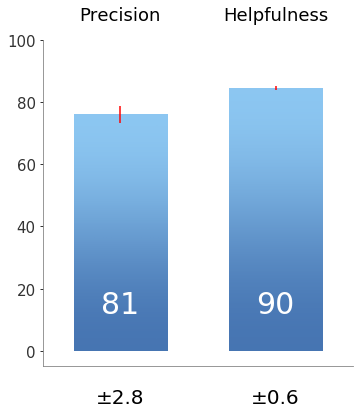

In [12]:
make_bar(avg_prec*100, avg_help*100, var_prec*100, var_help*100)

<a id="summ_metrics7"></a>
### 3.7 Summarize the root cause
Root causes describe issues caused by an incorrect or absent intent, entity, or dialog response.

#### 3.7.1 Display root causes summary

In [13]:
# Group by root causes and display count
root_cause = annotated_data['root_cause'].replace(r'^\s+$', np.nan, regex=True).dropna().value_counts().rename_axis('Root Causes').reset_index(name='Utterances')
# Apply style on dataframe
root_cause.style.set_table_styles(table_styles).set_properties(**{'text-align': 'center'}).set_properties(
                                                            subset=['Root Causes'], **{'width': '700px', 'text-align': 'left'}).format(
                                                            {'Utterances': lambda x: "{:.0f}".format(x)})


,Root Causes,Utterances
0,Entities,846
1,Intents,832
2,Dialog,777


#### 3.7.2 Save the results into a dataframe

In [14]:
# Create a dataframe to enclose the statistics computed so far
df = pd.DataFrame(OrderedDict( ( ('Intents', intents), ('True Positives', TP), ('False Positives', FP), ('True Negatives', TN), ('False Negatives', FN), ('Total Utterances (top intent)', num_total_per_intent[0]),('Total Utterances (ground truth)', num_total_per_intent_gt[0]), ('Total Errors', FP + FN))))



## 4. Perform intent analysis<a id="intent_analysis"></a>

Intent analysis is performed by looking for the dominant patterns of intent errors. An effective way to perform this analysis is to focus on four main categories of errors:

- **Worst overall performing intents:** these are intents that are most involved in a wrong answer, whether due to precision or recall.<p>
- **Worst recall intents:** this identifies intents that are being missed most often. This intent should have been given out, but other intent(s) are matching instead. These intents likely need more training examples. <p>
- **Worst precision intents:** this identifies intents that are frequently matching when they should not be, thus hiding the correct intent(s). These intents likely have training examples that clash with training of other intents. <p>
- **Most confused intent pairs:** these are pairs of intents that are often confused with each other. These intents likely have training examples that overlap. 

### <a id="intent_analysis1"></a> 4.1 Determine worst overall performing intents
These are intents that are most involved in a wrong answer, whether due to precision or recall. Here are the metrics we recommend measuring: 
- __False Positives__ of an intent describe cases where the intent classifier incorrectly classifies utterance as this intent.
- __False Negatives:__ of an intent describe cases where the intent classifier fails to classify an utterance as this intent.

In [15]:
output_file_path = 'WorstOverallIntents.csv'

display(md('<p>'))
display(md('<div style="max-width: 1300px;"><div style="float: left;">View the whole list here: <b><a href="{}" style="color:black"  target="_blank">WorstOverallIntents.csv</a></b></div><div style="float: right"> 25 Worst Intents </div></div>'.format(output_file_path)))

# Sort dataframe by number of errors and add related columns
worst_overall = df.sort_values('Total Errors', ascending=False)[['Intents','Total Utterances (top intent)','Total Utterances (ground truth)','Total Errors',
                                                              'False Positives', 'False Negatives'
                                                             ]].reset_index(drop=True)

# Save the output CSV file
worst_overall.to_csv(output_file_path, sep=',', encoding='utf-8')

# Apply style on dataframe table
worst_overall.head(15).style.set_table_styles(table_styles).set_properties(**{'text-align': 'center'}).set_properties(
                                                        subset=['Total Utterances (top intent)'], **{'width': '140px'}).set_properties(
                                                        subset=['Total Utterances (ground truth)'], **{'width': '160px'}).set_properties(
                                                        subset=['Total Errors'], **{'width': '100px'}).set_properties(subset=['Intents'], **{'width': '450px', 'text-align': 'left'})

<p>

<div style="max-width: 1300px;"><div style="float: left;">View the whole list here: <b><a href="WorstOverallIntents.csv" style="color:black"  target="_blank">WorstOverallIntents.csv</a></b></div><div style="float: right"> 25 Worst Intents </div></div>

,Intents,Total Utterances (top intent),Total Utterances (ground truth),Total Errors,False Positives,False Negatives
0,turn_on,755,241,786,650,136
1,capabilities,205,841,696,30,666
2,locate_amenity,721,670,155,103,52
3,turn_off,129,125,44,24,20
4,greetings,85,74,35,23,12
5,weather,112,98,34,24,10
6,turn_up,87,83,30,17,13
7,out_of_scope,51,42,21,15,6
8,goodbyes,41,41,14,7,7
9,positive_reaction,32,27,13,9,4


### <a id="intent_analysis2"></a> 4.2 Determine the worst precision intents

This identifies intents that are frequently matching when they should not be, thus hiding the correct intent(s). These intents likely have training examples that clash with training of other intents. Here are the metrics we recommend measuring: 

- __True Positives__ of an intent describe cases where the intent classifier correctly classifies utterance as this intent.
- __False Positives__ of an intent describe cases where the intent classifier incorrectly classifies utterance as this intent.

In [16]:
output_file_path = 'WorstPrecisionIntents.csv'

# Calculate precision by intents
TP_FP = TP+FP
percentile_list = pd.DataFrame({'True Positives': TP,'False Positives': FP, 'True&False Positive': TP_FP, 'Intents': intents})

# Remove invalid intent
invalid_intent_precision = percentile_list[percentile_list['True&False Positive']==0]['Intents']
percentile_list = percentile_list[percentile_list['True&False Positive']>0]

# Calculate precision per intent
percentile_list['Precision'] = percentile_list['True Positives'].divide(percentile_list['True&False Positive']).values

percentile_list = percentile_list.join(df[['Total Utterances (top intent)', 'Total Utterances (ground truth)']], on='Intents')

display(md('<p>'))
display(md('<div style="max-width: 1500px;"><div style="float: left">View the whole list here: <b><a href="{}"  style="color:black"  target="_blank">WorstPrecisionIntents.csv</a></b></div><div style="float: right"> 25 Worst Intents </div> </div>'.format(output_file_path)))

# Sort dataframe by precision and add related columns
worst_prec = percentile_list.sort_values(['Precision', 'False Positives'], ascending=[True, False])[['Intents','Total Utterances (top intent)', 'Total Utterances (ground truth)', 'True Positives', 
                                                           'False Positives', 'Precision']].reset_index(drop=True)

# Save the output CSV file
worst_prec.to_csv(output_file_path, sep=',', encoding='utf-8')

# Apply style on dataframe table
table = worst_prec.head(25).style.set_table_styles(table_styles).set_properties(**{'text-align': 'center'}).set_properties(
                                                        subset=['Total Utterances (top intent)'], **{'width': '140px'}).set_properties(
                                                        subset=['Total Utterances (ground truth)'], **{'width': '180px'}).set_properties(
                                                            subset=['Intents'], **{'width': '400px', 'text-align': 'left'}).format(
                                                            {"Precision": lambda x: "{:.0f}%".format(x*100)}).set_properties(
                                                            subset=['Precision'], **{'width': '350px', 'text-align': 'center'}).render()

# Apply CSS style
style = '.meter { height: 6px; width: 50%; position: relative; background: #fff; border-radius: 20px; border-color: rgb(0, 76, 192); border-style: solid; border-width: 1px; float: left; margin-top: 8px; margin-left: 50px;margin-right: 15px; } .meter>span { display: block; height: 100%; background-color: rgb(0, 76, 192); position: relative; overflow: hidden; } '
table = table[:table.find('>') + 1] + style + table[table.find('>') + 1:]

# Insert percentage bar
pattern = r'(data row)(.*?)( col5" >)(.*?)(%)(</td>)'
bar_code = r'<div class="meter"  style="float: left;margin-left: 30px;"> <span style="width: \4%"></span> </div><div style="float: left;margin-left: 0px;">'
regex = re.compile(pattern, re.IGNORECASE)
table = re.sub(pattern, r'\1\2\3'+bar_code+r'\4\5</div>\6', table)

if len(invalid_intent_precision) > 0:
    invalid_note = '<br><b>Note<b>: the following intents are ignored when calculating Precision due to the sum of True Positive and False Positive is zero<p>'
    for intent in invalid_intent_precision:
        invalid_note += '&emsp;{}<br>'.format(intent)
    table += invalid_note
# Show table
HTML(table)

<p>

<div style="max-width: 1500px;"><div style="float: left">View the whole list here: <b><a href="WorstPrecisionIntents.csv"  style="color:black"  target="_blank">WorstPrecisionIntents.csv</a></b></div><div style="float: right"> 25 Worst Intents </div> </div>

,Intents,Total Utterances (top intent),Total Utterances (ground truth),True Positives,False Positives,Precision
0,turn_on,755,241,105,650,14%
1,out_of_scope,51,42,36,15,71%
2,positive_reaction,32,27,23,9,72%
3,greetings,85,74,62,23,73%
4,decision_replies,37,29,27,10,73%
5,traffic_update,35,26,26,9,74%
6,turn_down,12,10,9,3,75%
7,about_VA,18,15,14,4,78%
8,weather,112,98,88,24,79%
9,phone,15,12,12,3,80%


### <a id="intent_analysis3"></a> 4.3 Determine the worst recall intents

This identifies intents that are being missed most often. This intent should have been given out, but other intent(s) are matching instead. These intents likely need more training examples. 

- __True Positives__ of an intent describe cases where the intent classifier correctly classifies utterance as this intent.
- __False Negative__ of an intent describe cases where the intent classifier fails to classify utterance as this intent.

In [17]:
output_file_path = 'WorstRecallIntents.csv'

# Calculate recall by intents
TP_FN = TP+FN
percentile_recall_list = pd.DataFrame({'True Positives': TP,'False Negatives': FN, 'Intents': intents, 'True Positive&False Negative': TP_FN})

# Remove invalid intent
invalid_intent_recall = percentile_recall_list[percentile_recall_list['True Positive&False Negative']==0]['Intents']
percentile_recall_list = percentile_recall_list[percentile_recall_list['True Positive&False Negative']>0]

# Calculate precision per intent
percentile_recall_list['Recall'] = percentile_recall_list['True Positives'].divide(percentile_recall_list['True Positive&False Negative']).values

percentile_recall_list = percentile_recall_list.join(df[['Total Utterances (top intent)', 'Total Utterances (ground truth)']], on='Intents')


display(md('<p>'))
display(md('<div style="max-width: 1500px;"><div style="float: left">View the whole list here: <b><a href="{}"  style="color:black"  target="_blank">WorstRecallIntents.csv</a></b></div><div style="float: right"> 25 Worst Intents </div></div>'.format(output_file_path)))

# Sort dataframe by recall and add related columns
worst_recall = percentile_recall_list.sort_values(['Recall', 'False Negatives'], ascending=[True, False])[['Intents','Total Utterances (top intent)','Total Utterances (ground truth)', 'True Positives', 'False Negatives',
                                                        'Recall']].reset_index(drop=True)

# Save the output CSV file
worst_recall.to_csv(output_file_path, sep=',', encoding='utf-8')

# Apply style on dataframe table
table = worst_recall.head(25).style.set_table_styles(table_styles).set_properties(**{'text-align': 'center'}).set_properties(
                                                        subset=['Total Utterances (top intent)'], **{'width': '140px'}).set_properties(
                                                        subset=['Total Utterances (ground truth)'], **{'width': '180px'}).set_properties(
                                                        subset=['Intents'], **{'width': '400px', 'text-align': 'left'}).format(
                                                        {"Recall": lambda x: "{:.0f}%".format(x*100)}).set_properties(
                                                        subset=['Recall'], **{'width': '350px', 'text-align': 'center'}).render()

# Apply CSS style
style = '.meter { height: 6px; width: 50%; position: relative; background: #fff; border-radius: 20px; border-color: rgb(0, 76, 192); border-style: solid; border-width: 1px; float: left; margin-top: 8px; margin-left: 50px;margin-right: 15px; } .meter>span { display: block; height: 100%; background-color: rgb(0, 76, 192); position: relative; overflow: hidden; } '
table = table[:table.find('>') + 1] + style + table[table.find('>') + 1:]

# Insert percentage bar
pattern = r'(data row)(.*?)( col5" >)(.*?)(%)(</td>)'
bar_code = r'<div class="meter"  style="float: left;margin-left: 30px;"> <span style="width: \4%"></span> </div><div style="float: left;margin-left: 0px;">'
regex = re.compile(pattern, re.IGNORECASE)
table = re.sub(pattern, r'\1\2\3'+bar_code+r'\4\5</div>\6', table)

if len(invalid_intent_recall) > 0:
    invalid_note = '<br><b>Note</b>: the following intents are ignored when calculating Recall due to the sum of True Positive and False Negative is zero<p>'
    for intent in invalid_intent_recall:
        invalid_note += '&emsp;{}<br>'.format(intent)
    table += invalid_note
# Show table
HTML(table)

<p>

<div style="max-width: 1500px;"><div style="float: left">View the whole list here: <b><a href="WorstRecallIntents.csv"  style="color:black"  target="_blank">WorstRecallIntents.csv</a></b></div><div style="float: right"> 25 Worst Intents </div></div>

,Intents,Total Utterances (top intent),Total Utterances (ground truth),True Positives,False Negatives,Recall
0,capabilities,205,841,175,666,21%
1,turn_on,755,241,105,136,44%
2,system_reliance,5,7,5,2,71%
3,compound_questions,13,15,11,4,73%
4,information_request,16,17,13,4,76%
5,interface_issues,4,5,4,1,80%
6,goodbyes,41,41,34,7,83%
7,negative_reaction,18,18,15,3,83%
8,greetings,85,74,62,12,84%
9,turn_off,129,125,105,20,84%


### <a id="intent_analysis4"></a> 4.4 Determine confused intent pairs
Most confused intent pairs: these are pairs of intents that are often confused with each other. Here is a description of the columns we focus on:
- __Intent 1, Intent 2:__ The pair of confused intents.
- __Incorrectly in Intent 1:__ Number of utterances where intent 1 was identified instead of intent 2.
- __Incorrectly in Intent 2:__ Number of utterances where intent 2 was identified instead of intent 1.

In [18]:
output_file_path = 'ConfusedIntentPairs.csv'

display(md('<p>'))
display(md('<div style="max-width: 1200px;"><div style="float: left">View the whole list here: <b><a href="{}"  style="color:black"  target="_blank">ConfusedIntentPairs.csv</a></b></div><div style="float: right"> 25 Worst Intents </div></div>'.format(output_file_path)))

# Calculate confused intents
# Merge two copies of the dataframe on ground truth and intent
copy1 = annotated_data.loc[annotated_data['top_intent']!=annotated_data['ground_truth'], ['ground_truth','top_intent']].groupby(['ground_truth','top_intent']).size().reset_index(name="Count").sort_values(by='Count', ascending = False)
copy2 = annotated_data.loc[annotated_data['top_intent']!=annotated_data['ground_truth'], ['ground_truth','top_intent']].groupby(['ground_truth','top_intent']).size().reset_index(name="Count").sort_values(by='Count', ascending = False)
result = pd.merge(copy1, copy2, left_on='ground_truth', right_on = 'top_intent')
if len(result) == 0:
    confused_intents = copy1.rename(columns={'ground_truth':'Intent 1', 'top_intent':'Intent 2', 'Count':'Incorrectly in Intent 2'})
    confused_intents['Incorrectly in Intent 1']=0
else:
    # Filter and rename columns
    confused_intents = result.loc[(result['ground_truth_x']==result['top_intent_y']) & (result['top_intent_x']==result['ground_truth_y'])].rename(columns={'ground_truth_x':'Intent 1', 'top_intent_x':'Intent 2', 'Count_x':'Incorrectly in Intent 2','Count_y':'Incorrectly in Intent 1'}).drop(['ground_truth_y','top_intent_y'], axis=1)
# Sort results
helper = pd.DataFrame(np.sort(confused_intents[['Intent 1', 'Intent 2']], axis=1), confused_intents[['Intent 1', 'Intent 2']].index, confused_intents[['Intent 1', 'Intent 2']].columns)
# Remove duplicates
helper.drop_duplicates(inplace = True)
# Perform an inner join to get most confused intents
most_confused_intents = pd.merge(helper, confused_intents, on=['Intent 1', 'Intent 2'], how = 'inner')
# Calculate 'Total wrong' column
most_confused_intents.insert(loc=0, column='Total Wrong', value=most_confused_intents['Incorrectly in Intent 1']+most_confused_intents['Incorrectly in Intent 2'])
# Get confused intent pairs - sorted by 'Total wrong' column
confused_intent_pairs = most_confused_intents[['Total Wrong','Intent 1', 'Intent 2', 'Incorrectly in Intent 1','Incorrectly in Intent 2']].sort_values(by = 'Total Wrong', ascending = False).reset_index(drop=True)

# Save the output CSV file
confused_intent_pairs.to_csv(output_file_path, sep=',', encoding='utf-8')

# Apply style on dataframe table
table = confused_intent_pairs.head(25).style.set_table_styles(table_styles).set_properties(**{'text-align': 'center'}).set_properties(
                                                        subset=['Intent 1', 'Intent 2'], **{'width': '300px', 'text-align': 'left'}).format(
                                                        {"Incorrectly in Intent 1": lambda x: "{:.0f}".format(x)}).set_properties(
                                                        subset=['Incorrectly in Intent 1','Incorrectly in Intent 2'], **{'width': '250px', 'text-align': 'center'}).render()

# Apply CSS style
style = '.dot {float: left; margin-left: 90px;margin-top: 4px; height: 10px; width: 10px; background-color: #4eaaf7; border-radius: 50%; display: inline-block; } .dot_mid {float: left; margin-left: 85px;margin-top: 4px; height: 10px; width: 10px; background-color: #fff; border-radius: 50%; display: inline-block; border-style: solid; border-width: 3px; border-color: #c819e0; }'
table = table[:table.find('>') + 1] + style + table[table.find('>') + 1:]

# Insert blue dots
pattern = r'(data row)(.*?)( col3" >)(.*?)(</td>)'
dot = r'<span class="dot"></span><div style="float: middle;margin-right: 60px;">'
regex = re.compile(pattern, re.IGNORECASE)
table = re.sub(pattern, r'\1\2\3'+dot+r'\4\5</div>', table)

# Insert pink dots
pattern = r'(data row)(.*?)( col4" >)(.*?)(</td>)'
dot = r'<span class="dot_mid"></span><div style="float: middle;margin-right: 60px;">'
regex = re.compile(pattern, re.IGNORECASE)
table = re.sub(pattern, r'\1\2\3'+dot+r'\4\5</div>', table)

# Insert blue dot into header
pattern = r'(col_heading level0 col1" >)(.*?)(</th>)'
dot = r'</div><div style="float:left;margin-left: -70px;"><span class="dot"></span></div>'
regex = re.compile(pattern, re.IGNORECASE)
table = re.sub(pattern, r'\1<div style="float:left;margin-left: 80px;">\2'+dot+r'\3', table)

# Insert pink dot into header
pattern = r'(col_heading level0 col2" >)(.*?)(</th>)'
dot = r'</div><div style="float:left;margin-left: -65px;"><span class="dot_mid"></span></div>'
regex = re.compile(pattern, re.IGNORECASE)
table = re.sub(pattern, r'\1<div style="float:left;margin-left: 80px;">\2'+dot+r'\3', table)

# Show table
HTML(table)

<p>

<div style="max-width: 1200px;"><div style="float: left">View the whole list here: <b><a href="ConfusedIntentPairs.csv"  style="color:black"  target="_blank">ConfusedIntentPairs.csv</a></b></div><div style="float: right"> 25 Worst Intents </div></div>

,Total Wrong,Intent 1,Intent 2,Incorrectly in Intent 1,Incorrectly in Intent 2
0,668,capabilities,turn_on,18,650
1,18,locate_amenity,turn_off,11,7
2,16,greetings,locate_amenity,9,7
3,13,capabilities,locate_amenity,8,5
4,12,locate_amenity,turn_up,8,4
5,9,locate_amenity,weather,3,6
6,7,locate_amenity,out_of_scope,2,5
7,5,locate_amenity,positive_reaction,2,3
8,5,greetings,weather,2,3
9,3,greetings,turn_off,2,1


## 5. Perform entity analysis<a id="entity_analysis"></a>

Entity analysis highlights the entities and entity values that are particularly problematic, so they can be targeted for further investigation and improvement. 

In [19]:
output_file_path = 'EntitiesMissed.csv'

# Get missed entity data from annotated_data dataframe
all_entities = annotated_data['missed_entity'].dropna().reset_index(drop = True)

# Convert the value into dict object
try:
    all_entities = all_entities.apply(lambda x: ast.literal_eval(x))
except:
    print("Malformed JSON annotation for entities, please check your annotation")
    for annotation in all_entities:
        print(annotation)
    raise

# There are multiple entities in a single column. Separate them so that there is only a single entity in a column
# Separate entities into different columns
entities_sep = pd.DataFrame(all_entities.values.tolist(), all_entities.index).add_prefix('entity_')

# Append all non-empty entities to a Series
series1 = pd.Series()
for col in entities_sep.columns:    
    series1 = series1.append(entities_sep[entities_sep[col].notnull()][col])
missed_entity_df = series1.to_frame('entities').reset_index(drop = True)
# Extract 'Entity' and 'Entity value' from dictionary to missed_entity
missed_entity_df['Entity'] = missed_entity_df['entities'].apply(lambda x: x['entity'])
missed_entity_df['Entity Value'] = missed_entity_df['entities'].apply(lambda x: x['value'])
missed_entity_df['Synonym'] = missed_entity_df['entities'].apply(lambda x: x['synonym'])
missed_entity = missed_entity_df[['Entity','Entity Value','Synonym']]

# Calculate the number of times an entity with a value was missed
missed_entity['Value Missed Count']=missed_entity.groupby(['Entity','Entity Value'])['Entity'].transform('count')

# Calculate the total number of times an entity was missed
missed_entity['Total Missed']= missed_entity.groupby(['Entity'])['Entity'].transform('count')

# Remove duplicates
missed_entity.drop_duplicates(keep = 'first', inplace=True)#sort_values(by='missed_entity')

# Create a pivot table with counts
df_pivot = pd.pivot_table(missed_entity, ['Value Missed Count'], ['Entity', 'Total Missed', 'Entity Value'])

# Sort the table by total missed count
missed_entities_all = df_pivot.reset_index().sort_values(['Total Missed','Entity','Value Missed Count'], ascending=False)

# Get the first 25 entities in a list
cols = missed_entities_all['Entity'].unique()[:25]

# Set index of dataframe
missed_entities_all = missed_entities_all.reset_index(drop = True).set_index(['Entity','Total Missed','Entity Value'])
idx = pd.IndexSlice

# Save the output CSV file
missed_entities_all.to_csv(output_file_path, sep=',', encoding='utf-8')

display(md('<p>'))
display(md('<div style="max-width: 800px;"><div style="float: left">View the whole list here: <b><a href="{}"  style="color:black"  target="_blank">EntitiesMissed.csv</a></b></div><div style="float: right">  </div></div>'.format(output_file_path)))

# Show the first 25 most missed entities
missed_entities_all

<p>

<div style="max-width: 800px;"><div style="float: left">View the whole list here: <b><a href="EntitiesMissed.csv"  style="color:black"  target="_blank">EntitiesMissed.csv</a></b></div><div style="float: right">  </div></div>

Value Missed Count
Entity         Total Missed Entity Value                    
cuisine        529          seafood                      252
                            burgers                      155
                            tacos                         89
                            pasta                         33
genre          213          rock                          88
                            pop                           82
                            jazz                          43
amenity        136          gas                           46
                            place                         44
                            restroom                      25
                            restaurant                    20
                            institute                      1
genre_bad      69           Blues                         34
                            Country                       24
                            Dance                          8
                            Hip Hop                        3
response_types 68           negative                      45
                            uncertain                     16
                            positive                       7
appliance      50           AC                            26
                            fan                           24

## 6. Perform dialog analysis<a id="dialog_analysis"></a>

Dialog analysis highlights instances where dialog problems were the root cause of the ineffectiveness. Dialog could be the problem because either the wrong response condition was triggered or because there was no response condition in place to handle the user message. These situations are used as candidates for improvement.  

In [20]:
# Get dialog data from annotated_data dataframe
wrong_node_df = annotated_data['wrong_dialog_node'].value_counts().rename_axis('Node Name').reset_index(name='Node Count')
table = ''
if len(wrong_node_df) > 0:
    # Add a new column with reason for 'wrong dialog node'
    wrong_node_df.insert(loc=0, column='Dialog', value='Wrong node response triggered')
    # Find the number of times 'wrong node response' was triggered
    wrong_node_df['Utterances'] = wrong_node_df.groupby('Dialog')['Node Count'].transform(sum)
else:
    print('No annotation data for \'Wrong node response triggered\'')
if len(annotated_data['no_dialog_node_triggered'].dropna()) > 0:
    # Find the number of times 'no node response' was triggered
    wrong_node_df.loc[len(wrong_node_df)] = ['No node response triggered', 'N/A', 0, annotated_data['no_dialog_node_triggered'].value_counts()['Y']]
else:
    print('No annotation data for \'No node response triggered\'')
if len(wrong_node_df) > 0:
    # Create a pivot table with counts
    table = pd.pivot_table(wrong_node_df, ['Node Count'], ['Dialog','Utterances','Node Name']).to_html()
HTML(table)

<a id="summary"></a>
## 7. Summary and recommendation

This Notebook shows you the following summary metrics based on your assessment:
1. The overall precision and helpfulness of your assistant’s responses  
2. Intent analysis
3. Entity analysis
4. Dialog analysis<br>

To improve the performance of your assistant service, based on the above results, we provide the following recommendations and resources:

#### Recommendations:

- Entity
    * Use <a href=https://console.bluemix.net/docs/services/conversation/entities.html#synonyms target="_blank">Synonym Recommender</a> to improve the top missed entitied indentified in [Entity Analysis](#entity_analysis).
    * Check and add the newly marked entities from <em>entity</em> sheet in [recommendation.xlsx](#improvement_recommendation) into your workspace and use <a href=https://console.bluemix.net/docs/services/conversation/entities.html#synonyms target="_blank">Synonym Recommender</a> to enrich the list of various entity values.
    * Check and import newly identified entity values, from <em>entity_value</em> sheet in [recommendation.xlsx](#improvement_recommendation), into your workspace.
    * Check and import the missed entity value synonyms, from <em>synonym</em> sheet in [recommendation.xlsx](#improvement_recommendation), into your workspace.

- Intent
    * Use intent <a href=https://console.bluemix.net/docs/services/conversation/intents.html#conflict-intents target="_blank">Conflict Resolver</a> to improve the top confused intent pair indentified in [Confused Intent Analysis](#intent_analysis4).
    * Check and import newly marked intent training utterance list, from <em>intent</em> sheet in [recommendation.xlsx](#improvement_recommendation), into your workspace.

- Dialog
    * Check the top problematic dialog nodes identified in [Dialog Analysis](#dialog_analysis).

After those updates have been performed, you have the option to continue focusing your improvement efforts on any trouble spots identified during the Analyze phase.

For more information, please check <a href="https://github.com/watson-developer-cloud/assistant-improve-recommendations-notebook/raw/master/notebook/IBM%20Watson%20Assistant%20Continuous%20Improvement%20Best%20Practices.pdf" target="_blank" rel="noopener noreferrer">Watson Assistant Continuous Improvement Best Practices</a>.

Create the `recommendation.xlsx` file now.

In [21]:
# Collect newly identified entities for training
new_entity = annotated_data['new_entity'].dropna().reset_index(drop = True)

# Convert the value into dict object
new_entity = new_entity.apply(lambda x: ast.literal_eval(x))

# Separate entities into different columns
new_entity_sep = pd.DataFrame(new_entity.values.tolist(), new_entity.index).add_prefix('entity_')

# Append all non-empty entities to a Series
series1 = pd.Series()
for col in new_entity_sep.columns:    
    series1 = series1.append(new_entity_sep[new_entity_sep[col].notnull()][col])
new_entity = series1.to_frame('entities').reset_index(drop = True)

# Extract 'Entity' and 'Entity value' from dictionary to missed_entity
new_entity['Entity'] = new_entity['entities'].apply(lambda x: x['entity']).drop_duplicates()

# Collect newly identified entity values for training
new_entity_value = annotated_data['new_entity_value'].dropna().reset_index(drop = True)

# Convert the value into dict object
new_entity_value = new_entity_value.apply(lambda x: ast.literal_eval(x))

# Separate entities into different columns
new_entity_value_sep = pd.DataFrame(new_entity_value.values.tolist(), new_entity_value.index).add_prefix('entity_')

# Append all non-empty entities to a Series
series1 = pd.Series()
for col in new_entity_value_sep.columns:    
    series1 = series1.append(new_entity_value_sep[new_entity_value_sep[col].notnull()][col])
new_entity_value = series1.to_frame('entities').reset_index(drop = True)

# Extract 'Entity' and 'Entity value' from dictionary to missed_entity
new_entity_value['Entity'] = new_entity_value['entities'].apply(lambda x: x['entity'])
new_entity_value['Entity Value'] = new_entity_value['entities'].apply(lambda x: x['value'])

new_entity_value = new_entity_value[['Entity', 'Entity Value']].drop_duplicates()

try:
  missed_entity
except NameError:
  new_entity_synonym = pd.DataFrame(columns=['Entity','Entity Value','Synonym'])
  print('No missing entity in annotation')
else:
    # Collect newly identified synonyms for training
    new_entity_synonym = missed_entity[['Entity','Entity Value','Synonym']].drop_duplicates()

# Collect utterance marked as adding for training
new_train_utterance = annotated_data.loc[annotated_data['add_train'] == 'Y'][['utterance_text','top_intent']].reset_index(drop = True)

generate_excel_effectiveness([new_entity['Entity'], new_entity_value, new_entity_synonym, new_train_utterance], ['entity', 'entity_value','synonym', 'intent'], filename = 'recommendation.xlsx', project_io = None)        

display(md('### Resources:'))
display(md('- <a id="improvement_recommendation"></a>Improvement recommendation: <a href="{}"  target="_blank">recommendation.xlsx</a>'.format('recommendation.xlsx')))

### Resources:

- <a id="improvement_recommendation"></a>Improvement recommendation: <a href="recommendation.xlsx"  target="_blank">recommendation.xlsx</a>

### <a id="authors"></a> Authors

**Zhe Zhang**, Ph.D. in Computer Science, is a Software Engineer for IBM Watson AI. Zhe has a research background in Natural Language Processing, Sentiment Analysis, Text Mining, and Machine Learning. His research has been published at leading  conferences and journals including ACL and EMNLP.

**Sherin Varughese** is a Data Scientist for IBM Watson AI. Sherin has her graduate degree in Business Intelligence and Data Analytics and has experience in Data Analysis, Warehousing and Machine Learning.

### <a id="acknowledgement"></a> Acknowledgement

The authors would like to thank the following members of the IBM Research and Watson Assistant teams for their contributions and reviews of the notebook:  Matt Arnold, Adam Benvie, Kyle Croutwater, Eric Wayne.

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.